# NVDM

Re-adapt NVDM code for unified notebook.
The main difference is using sklearn's CountVectorizer like the other models.
Unlike the original notebook, which passes in business descriptions as variable-length sequences,
we directly pass in bag-of-words (generated using the count-vectorizer).
This results in much faster training as well.

In [1]:
import os
import string
import pathlib
import pickle
from timeit import default_timer as timer
from datetime import timedelta

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [32]:
# PyTorch stuff
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

# Autoselect target device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [6]:
%load_ext autoreload
%autoreload 2

from models import nvdm

## Helper Functions

In this section, we provide helper function definitions.

### Preprocessing

In [7]:
# Instance of Lemmatizer
LEMMATIZER = WordNetLemmatizer()
STOPWORDS = stopwords.words('english')

def preprocess_text(text):
    """ Process a single line of text. """

    # Strip trailing characters if any (e.g. newline)
    text_new = text.strip()
    
    # Remove puncuation
    text_new = ''.join(ch for ch in text_new if ch not in string.punctuation)

    # Lower case
    text_new = text_new.lower()
    
    # Tokenise by space
    tokens = text_new.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]

    # Lemmatise each word
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    
    text_new = ' '.join(tokens)

    return text_new

### Model Definitions

We experimented with three types of model:

- K-Means
- Latent Dirichlet Allocation (LDA)
- Neural Variational Document Modelling (NVDM)

For this demo, we only show the "best" model for each type. Please refer to the report and model-specific notebooks for details on hyperparameter selection.

In [8]:
class Model:
    """ Base class for clustering models.
    
    Basically a wrapper for a variety of models.
    """
    def __init__(self):
        pass
    
    def fit(self, X):
        """ Train the model. """
        raise NotImplementedError()
    
    def transform(self, X):
        """ Apply model to new data. """
        raise NotImplementedError()
    
    @property
    def topic_vocab_matrix(self):
        """ Each model should be able to return a topic-vocab matrix
        containing a score (e.g. probability) of a word in the vocabulary
        occuring in the k^th topic. """
        pass

class NVDMModel(Model):
    """ PyTorch NVDM model.
    
    Loads a pretrained model from disk.
    """
    def __init__(self):
        pass
    
    def fit(self, X):
        """ We don't train the model here because it takes too long. """
        pass
    
    def transform(self, X):
        pass
    
    @property
    def topic_vocab_matrix(self):
        """ Returns the learned semantic embeddings of each word. """
        decoder = self.model.decoder[0]
        weights = decoder.weight.data.detach().clone().numpy()
        return weights.T

### Evaluation

We provide functions for evaluation below.
The _topic coherence_ metric is used. TODO perplexity for LDA and NVDM.

In [9]:
# Topic coherence.
def umass_score(tf):
    """ Compute topic coherence using UMass metric.
    
    Ref: http://qpleple.com/topic-coherence-to-evaluate-topic-models/
    
    tf: term-frequency matrix for each document.
        Each i^th row is the BOW representation of the i^th document.
    """
    
    # D(wi): count of documents containing the word wi (i.e. df)
    Dwi = np.array(np.sum(tf > 0, axis=0))[0]

    W_bin = np.zeros_like(tf)
    W_bin[tf > 0] = 1
    
    # D(wi, wj): count of documents containing both words wi and wj
    Dwi_wj = W_bin.T @ W_bin

    score_umass = np.log((Dwi_wj + 1)/ Dwi)
    
    return score_umass

def topic_coherence(topic_vocab, n_top_words, pair_score):
    """ Compute the topic coherence of each topic,
    given a learned topic-vocabulary matrix, the number of top words to use
    and a matrix of pairwise scores (e.g. umass_score output)
    
    topic_vocab: dimensions (number of topics, vocabulary size).
    model.components_ for LDA, and the "semantic embedding" matrix in the decoder for NVDM.
    
    pair_score: matrix of scores (e.g. UMass)
    """
    coherences = []
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        coh = 0
        for i in range(len(top_features_ind)):
            for j in range(i):
                coh += pair_score[top_features_ind[i], top_features_ind[j]]
        coherences.append(coh)
    return coherences

def plot_top_words(topic_vocab, feature_names, n_top_words, title):
    """ Given a topic-vocabulary matrix containing scores
    (e.g. probabilities, higher the better),
    plot the top words as a frequency bar-graph for each topic.
    
    e.g. set topic_vocab=model._components for LDA.
    """
    K = len(topic_vocab)
    n_x = 5
    n_y = int(np.ceil(K / n_x))
    fig, axes = plt.subplots(n_y, n_x, figsize=(2.5 * n_x, 4 * n_y), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    # plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    fig.tight_layout()
    plt.show()

### Data-Loading

Functions for loading all business description datasets (S&P500 and bds1).

In [10]:
def load_sp500(path, preprocess=False):
    """ Load S&P500 data from the per-company text files in the supplied directory path.
    
    Within the directory, each file is named "<ticker>_<sector>.txt".
    Each contains the business description (BD) of the company.
    
    If preprocess is True, the preprocess the business descriptions at the same time.
    """
    filenames = os.listdir(path)

    tickers = []
    sectors = []
    bds = []
    for fn in filenames:
        prefix = fn.split('.txt')[0]
        ticker, sector = prefix.split('_')
        filepath = os.path.join(path, fn)
        with open(filepath, 'r', encoding="utf8") as f:
            bd = f.read().strip()
        
        if preprocess:
            bd = preprocess_text(bd)

        tickers.append(ticker)
        sectors.append(sector)
        bds.append(bd)
    
    return tickers, sectors, bds


def load_bds1(path, preprocess=False, exclude_tickers=None):
    """ Load data from the business data, given the file path (e.g. "data/bds_1.txt").
    
    In the file, each company has two consecutive lines.
    The first line is <company ticker>:<CIK> (we only care about the ticker)
    and the second line is the company business description.
    
    exclude_tickers is a list of tickers that we want to ignore in bds_1.txt.
    For example, we can use this to exclude any S&P500 companies to avoid
    overlapping of datasets.
    """
    
    with open(path, "r", encoding="utf8") as f:
        lines = f.readlines()

    company_ids_all = [ln.strip() for ln in lines[0::2]]
    company_descriptions_all = [ln.strip() for ln in lines[1::2]]
    company_tickers = [x.split(':')[0] for x in company_ids_all]

    exclusion_set = set(exclude_tickers) if exclude_tickers is not None else set()

    tickers = []
    bds = []
    
    # Some business descriptions are too short (or even empty),
    # so we only keep those with a length (number of characters) deemed reasonable.
    bd_valid_length = 3000
    for ticker, bd in zip(company_tickers, company_descriptions_all):
        if ticker not in exclusion_set and len(bd) >= bd_valid_length:
            tickers.append(ticker)
            
            if preprocess:
                bd = preprocess_text(bd)
            bds.append(bd)
    
    return tickers, bds

## Begin Demo

In [11]:
%%time
# Load and preprocess S&P500 and BDS1 data.
# We use BDS1 as the training set and S&P500 as the validation set.
sp500_tickers, sp500_sectors, sp500_bds = load_sp500("../SP500", preprocess=True)
bds1_tickers, bds1_bds = load_bds1("./data/bds_1.txt", preprocess=True, exclude_tickers=sp500_tickers)

CPU times: user 1min 6s, sys: 337 ms, total: 1min 7s
Wall time: 1min 7s


In [12]:
# FEATURE EXTRACTION
# Use this to convert text to a Bag-of-Words (term-frequency) representation.
# We "train" this vectorizer on S&P500 only, assuming the BDS1 validation set is "unseen".
# When evaluating, if a word in a business description from BDS1 doesn't exist in S&P500 data,
# then it will be ignored.

# Only keep top n most frequent words (adjust futher if required)
# These parameters (except stopwords, since they are already removed)
# were used in LDA notebooks. Adjust if needed.
n_features = 4000
tf_vectorizer = CountVectorizer(max_features=n_features, max_df=0.95, min_df=2)
tf_vectorizer.fit(sp500_bds)

CountVectorizer(max_df=0.95, max_features=4000, min_df=2)

In [13]:
X_sp500 = tf_vectorizer.transform(sp500_bds).todense()

In [14]:
class BDDataset(Dataset):
    """ Very simple dataset object. Stores all the passages.
    
    This is just for compatibility with PyTorch DataLoader.
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
def train(model, data_loader, outer_epochs=1000, print_every=100, device="cpu"):

    # Trains both the encoder and decoder at the same time.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    start_time = timer()
    print("Start training...")


    for epoch in range(outer_epochs):

        loss_sum = 0.0
        rec_sum = 0.0
        kl_sum = 0.0
        n = len(data_loader)

        for text in data_loader:
            text = text.to(device)

            optimizer.zero_grad()
            loss_dict = model(text, kl_weight=1.0)
            loss = loss_dict["total"].sum()
            loss.backward()

            optimizer.step()

            # For printing
            loss_sum += loss.item()
            rec_sum += loss_dict["rec"].sum().item()
            kl_sum += loss_dict["kl"].sum().item()

        if (epoch + 1) % print_every == 0:
            print(f"[Time: {timedelta(seconds=timer() - start_time)}, Epoch {epoch + 1}] Loss {loss_sum/n}, Rec {rec_sum/n}, KL {kl_sum/n}")

In [16]:
# Create data loader to iterate over dataset in batches during training/evaluation
dataset = BDDataset(torch.tensor(X_sp500, dtype=torch.float32))
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
hidden_size = 500
num_topics = 15

In [17]:
vocab_size = len(tf_vectorizer.get_feature_names())
model = nvdm.NVDM(vocab_size, hidden_size, num_topics, 1, device)
model = model.to(device)
model.train()
train(model, data_loader, outer_epochs=5000, print_every=500, device=device)

Start training...
[Time: 0:00:02.568916, Epoch 100] Loss 1702318.4375, Rec 1697877.265625, KL 4441.187805175781
[Time: 0:00:05.150865, Epoch 200] Loss 1680175.3125, Rec 1675553.875, KL 4621.430877685547
[Time: 0:00:07.743113, Epoch 300] Loss 1674282.828125, Rec 1669750.984375, KL 4531.799987792969
[Time: 0:00:10.336661, Epoch 400] Loss 1672329.421875, Rec 1667921.8125, KL 4407.631896972656
[Time: 0:00:12.947881, Epoch 500] Loss 1670870.25, Rec 1666570.703125, KL 4299.537536621094
[Time: 0:00:15.554298, Epoch 600] Loss 1670090.4375, Rec 1665947.328125, KL 4143.09375
[Time: 0:00:18.152518, Epoch 700] Loss 1669631.28125, Rec 1665567.140625, KL 4064.1722717285156
[Time: 0:00:20.749185, Epoch 800] Loss 1669493.078125, Rec 1665476.421875, KL 4016.69482421875
[Time: 0:00:23.355198, Epoch 900] Loss 1668959.609375, Rec 1665066.640625, KL 3893.016815185547
[Time: 0:00:25.971967, Epoch 1000] Loss 1668317.703125, Rec 1664492.875, KL 3824.8028259277344
[Time: 0:00:28.590026, Epoch 1100] Loss 166824

In [18]:
# Extract the vocab-topic matrix (known as R in the paper).
# It has dimensions |V| x K: vocab size x number of topics
decoder = model.decoder[0]
weights = decoder.weight.data.detach().clone()
weights.size()

torch.Size([4000, 15])

In [19]:
# Look at some example words and their "nearest" words
# according to their learned semantic word embeddings.
candidates = ["medical", "technology", "mining"]

# Convert string tokens to their integer ID and vice versa.
stoi = tf_vectorizer.vocabulary_
itos = tf_vectorizer.get_feature_names()

for test_word in candidates:
    idx = stoi[test_word]
    print(test_word, idx)

    # Show top 10 most similar (based on cosine distance)
    sims = F.cosine_similarity(weights[idx].unsqueeze(0), weights)
    sim_vals, sim_idxs = torch.topk(sims, 50)

    # Show ith nearest word and its score.
    for i, v in zip(sim_idxs, sim_vals):
        print(f"{itos[i]}\t{v.item()}")
    
    print("-----------")

medical 2369
medical	1.0
physician	0.8671005368232727
medicare	0.7989314794540405
hospital	0.7836596369743347
surgical	0.7744660377502441
clinician	0.7555355429649353
catheter	0.751934289932251
patient	0.7511759996414185
care	0.7504316568374634
surgery	0.7286518216133118
nurse	0.7270124554634094
interventional	0.7133541107177734
pain	0.7127078771591187
heart	0.712287962436676
disease	0.710130512714386
clinical	0.7091981768608093
diagnosis	0.6998069882392883
fda	0.6938768029212952
acute	0.6867314577102661
healthcare	0.6672387719154358
pma	0.6663665771484375
diagnostic	0.6647933125495911
reimbursement	0.6599975824356079
cardiovascular	0.6581945419311523
disorder	0.658182680606842
adherence	0.6534446477890015
medicaid	0.6499167084693909
invasive	0.6444401144981384
payors	0.6425896286964417
tissue	0.6370396018028259
treat	0.635930061340332
outpatient	0.6339256167411804
chronic	0.6330421566963196
premarket	0.6325215697288513
valve	0.6313896775245667
clinic	0.6275714635848999
practitioner	0.

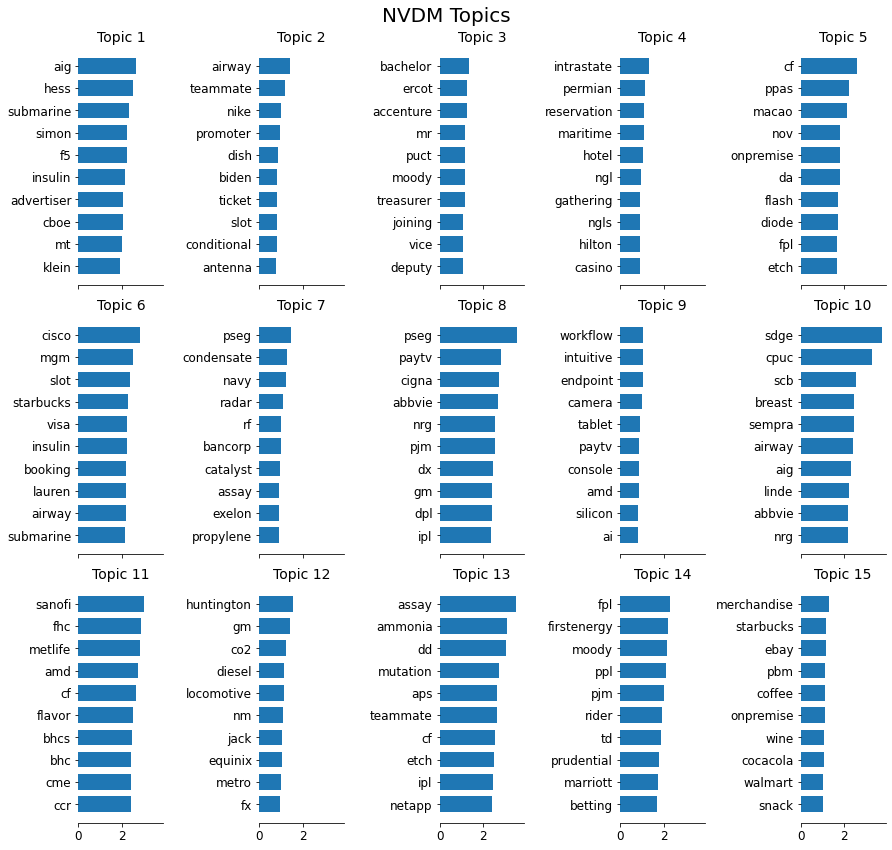

In [20]:
decoder = model.decoder[0]
weights = decoder.weight.data.detach().clone().cpu().numpy()
topic_vocab_mat = weights.T

plot_top_words(topic_vocab_mat, tf_vectorizer.get_feature_names(), 10, f"NVDM Topics")

In [21]:
def perplexity(model, dataset, n_sample):
    """ Compute perplexity of PyTorch model on the PyTorch Dataset. """

    # Iterate over the whole dataset once (1 big batch).
    data_loader = DataLoader(dataset,
                             batch_size=len(dataset),
                             shuffle=False)
    assert len(data_loader) == 1

    for text in data_loader:
        text = text.to("cpu")

        with torch.no_grad():

            # Estimate the loss for each document by sampling
            loss_dict = model(text, kl_weight=1.0, n_sample=n_sample)
            loss = loss_dict["total"]

            # According to the NVDM paper, we estimate log probabilities using
            # the variational lower bound (negative of loss).
            log_probs = -loss

            # Perplexity below...
            
            # Length of each document is the sum of its bag-of-words vectpr
            doc_lengths = text.sum(dim=1)

            # Average over the words for each document
            ppx_doc = log_probs / doc_lengths

            # Perplexity: argument averages over documents
            ppx = torch.exp(-ppx_doc.mean()).item()

            return ppx

In [22]:
# Compute perplexity example
model = model.to("cpu")
model.device = "cpu"
model.eval()

perplexity(model, dataset, 20)

1139.5369873046875

In [23]:
# Used for topic coherence
score_umass_mat = umass_score(X_sp500)

In [24]:
k_values = [10, 50, 100, 150, 200, 300, 500]

models_k = dict()
vocab_size = len(tf_vectorizer.get_feature_names())

for k in k_values:
    print(f"Training k={k}...")
    model = nvdm.NVDM(vocab_size, hidden_size, k, 1, device)
    model = model.to(device)
    model.train()
    train(model, data_loader, outer_epochs=1000, print_every=1000, device=device)
    models_k[k] = model

Training k=10...
Start training...
[Time: 0:00:26.290144, Epoch 1000] Loss 1684316.390625, Rec 1681116.59375, KL 3199.7786254882812
Training k=50...
Start training...
[Time: 0:00:27.226189, Epoch 1000] Loss 1628633.8125, Rec 1620603.875, KL 8029.9417724609375
Training k=100...
Start training...
[Time: 0:00:28.338321, Epoch 1000] Loss 1607131.078125, Rec 1593442.5625, KL 13688.526489257812
Training k=150...
Start training...
[Time: 0:00:29.521323, Epoch 1000] Loss 1594936.515625, Rec 1576334.6875, KL 18601.770263671875
Training k=200...
Start training...
[Time: 0:00:30.774623, Epoch 1000] Loss 1590082.015625, Rec 1567579.78125, KL 22502.22998046875
Training k=300...
Start training...
[Time: 0:00:32.289579, Epoch 1000] Loss 1590419.75, Rec 1562971.65625, KL 27448.1328125
Training k=500...
Start training...
[Time: 0:00:37.358495, Epoch 1000] Loss 1593377.96875, Rec 1565522.96875, KL 27854.984619140625


In [26]:
k_values.sort()
tc_values = []
ppx_values = []

for k in k_values:
    print(f'Running k = {k}')
    this_model = models_k[k]
    
    this_model.device = "cpu"
    this_model = this_model.cpu()
    this_model.eval()
    
    # Extract the topic vocab matrix
    decoder = this_model.decoder[0]
    weights = decoder.weight.data.detach().clone().cpu().numpy()
    topic_vocab_mat = weights.T
    coherences = topic_coherence(topic_vocab_mat, 10, score_umass_mat)
    this_c = np.mean(coherences)

    # Topic coherence
    tc_values.append(this_c)
    
    # Perplexity
    ppx = perplexity(this_model, dataset, 20)
    ppx_values.append(ppx)

Running k = 10
Running k = 50
Running k = 100
Running k = 150
Running k = 200
Running k = 300
Running k = 500


Text(0, 0.5, 'Topic Coherence')

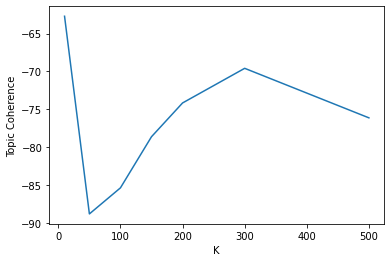

In [27]:
plt.plot(k_values, tc_values)
plt.xlabel("K")
plt.ylabel("Topic Coherence")

Text(0, 0.5, 'Perplexity')

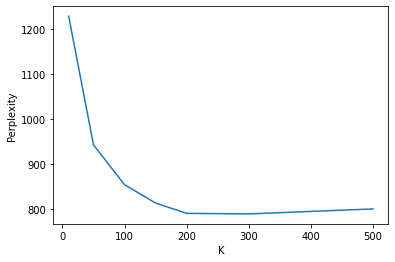

In [28]:
plt.plot(k_values, ppx_values)
plt.xlabel("K")
plt.ylabel("Perplexity")

In [30]:
# It appears that between 200 and 300 topics has the best balance between topic coherence and perplexity.
best_model = nvdm.NVDM(vocab_size, hidden_size, 300, 1, device)
best_model = best_model.to(device)
best_model.train()
train(best_model, data_loader, outer_epochs=1000, print_every=200, device=device)

MODELSAVE_PATH = "./modelsaves/nvdm_k300_1000epochs.pt"
torch.save(best_model.state_dict(), MODELSAVE_PATH)

Start training...
[Time: 0:00:06.484141, Epoch 200] Loss 1618104.859375, Rec 1597391.984375, KL 20712.864501953125
[Time: 0:00:12.916568, Epoch 400] Loss 1602219.328125, Rec 1577814.671875, KL 24404.6650390625
[Time: 0:00:19.296964, Epoch 600] Loss 1595320.015625, Rec 1569233.296875, KL 26086.71826171875
[Time: 0:00:25.669732, Epoch 800] Loss 1591606.28125, Rec 1564635.40625, KL 26970.868896484375
[Time: 0:00:32.038787, Epoch 1000] Loss 1590042.28125, Rec 1562623.34375, KL 27418.890625
